# ROOT Data Frame

Simple yet powerful way to analyse data with modern C++

Provide high-level features, e.g. less typing, better expressivity, abstraction of complex operations

Allow transparent optimisations, e.g. multi-thread parallelisation and caching

# ROOT Data Frame

What we write

```
TTreeReader reader(data);
TTreeReaderValue<A> x(reader,"x");
TTreeReaderValue<B> y(reader,"y");
TTreeReaderValue<C> z(reader,"z");
while (reader.Next()) {
   if (IsGoodEntry(*x, *y, *z))
      h->Fill(*x);
}
```

but we *only* care about the last 2 lines of code.


# ROOT Data Frame

We do have:

* full control over the event loop

but

* requires some boilerplate
* users implement common tasks again and again
* parallelisation is not trivial


## TDataFrame: declarative analyses
```
TDataFrame d(data);
auto h = d.Filter(IsGoodEntry, {"x","y","z"})
          .Histo1D("x");
```

* full control over the analysis
* no boilerplate
* common tasks are already implemented

* parallelization is not trivial?



## TDataFrame: declarative analyses
```
ROOT::EnableImplicitMT();
TDataFrame d(data);
auto h = d.Filter(IsGoodEntry, {"x","y","z"})
          .Histo1D("x");
```

* full control over the analysis
* no boilerplate
* common tasks are already implemented

* parallelization is trivial



## TDataFrame: quick how-to

1. build a data-frame object by specifying your data-set
1. apply a series of transformations to your data
 1. filter (e.g. apply some cuts) or
 1. define new columns
1. apply actions to the transformed data to produce results (e.g. fill a histogram) 

## Creating a TDataFrame - 1 file

Three ways to create a TDataFrame that reads tree “treename” from file “file.root”

```
TDataFrame d1("treename", "file.root");

auto filePtr = TFile::Open("file.root");
TDataFrame d2("treename", filePtr);

TTree *treePtr = nullptr;
filePtr->GetObject("treename", treePtr);
TDataFrame d3(*treePtr); // by reference!
```

## Creating a TDataFrame - more files

Here TDataFrame reads tree “treename” from files “file1.root” and “file2.root”

```
TDataFrame d1("treename", "file*.root");
TDataFrame d2("treename", {"file1.root", "file2.root"});

std::vector<std::string> files = {"file1.root", "file2.root"};
TDataFrame d3("treename", files);

TChain chain("treename");
chain.Add("file1.root); chain.Add("file2.root);
TDataFrame d4(chain); // passed by reference, not pointer!
```

## Cut on theta, fill histogram with pt

Event-loop is run lazily, upon first access to the results

```
TDataFrame d("t", "f.root");
auto h = d.Filter("theta > 0").Histo1D("pt");
h->Draw(); // event loop is run here, when you access a result
           // for the first time
```



## Time For Exercises

Draw a plot of px + py for every pz between -2 and 2 using the hsimple.root file

* Use TDataFrame
* Compare with the other approaches:
 * number of lines
 * readability


In [ ]:
import ROOT
TDF = ROOT.ROOT.Experimental.TDataFrame

In [ ]:
d = TDF("ntuple", "$ROOTSYS/tutorials/hsimple.root");

In [ ]:
h1 = d.Filter("-2 < pz && pz < 2").Define("sum","px + py").Histo1D("sum");

In [ ]:
h1.Draw()

## Think of your analysis as data-flow

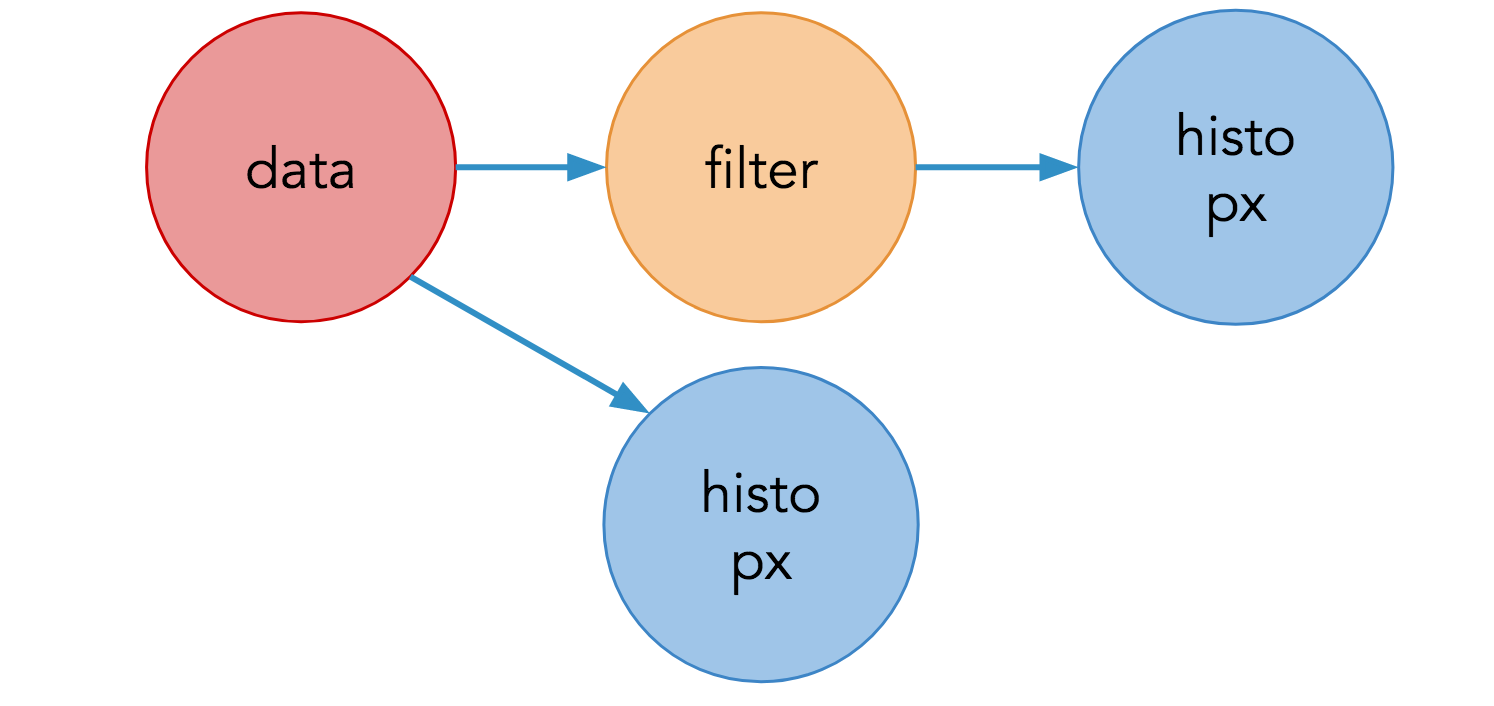

In [ ]:
h2 = d.Filter("pz > 0").Histo1D("px");

In [ ]:
h3 = d.Histo1D("px");

## Using callables instead of strings

any callable (function, lambda, functor class) can be used as a filter, as long as it returns a boolean (C++)

```
// define a c++11 lambda - an inline function - that checks “x>0”
auto IsPos = [](double x) { return x > 0.; };
// pass it to the filter together with a list of branch names
h4 = d.Filter(IsPos, {"theta"}).Histo1D("pt");
```

## Filling multiple histograms

Book all your actions upfront. The first time a result is accessed, TDataFrame will fill all booked results.

In [ ]:
h4 = d.Filter("pz > 0").Histo1D("px");
h5 = d.Filter("pz < 0").Histo1D("px");

In [ ]:
h4.Draw();       // event loop is run once here

In [ ]:
h5.Draw("SAME"); // no need to run loop again here 

## Define a new column

`Define` takes the name of the new column and its expression. Later you can use the new column as if it was present in your data. 

In [ ]:
m = d.Filter("px > py")
     .Define("sq", "sqrt(px*px + py*py)")
     .Mean("sq");

Just like `Filter`, `Define` accepts any callable object (function, lambda, functor class…)

```
double SqrtSumSq(double, double) { return … ; }
double m = d.Filter("x > y")
            .Define("z", SqrtSumSq, {"x","y"})
            .Mean("z");
```

## Think of your analysis as data-flow

You can store transformed data-frames in variables, then use them as you would use a TDataFrame.

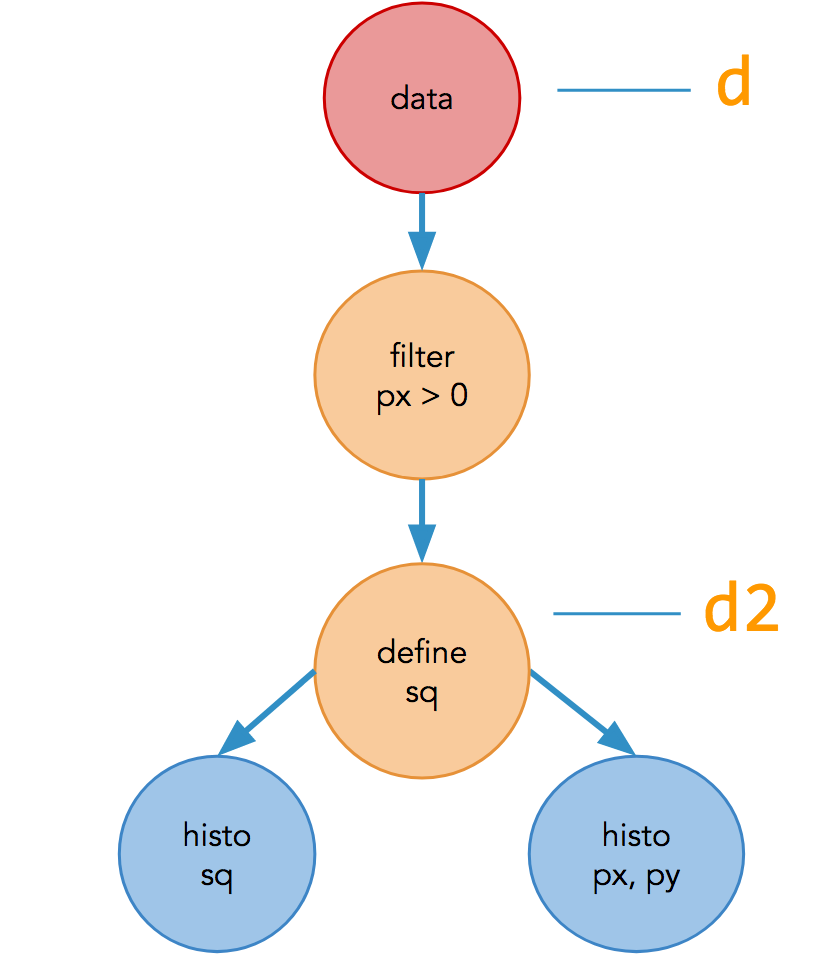

In [ ]:
# d2 is a new data-frame, a transformed version of d
d2 = d.Filter("px > 0").Define("sq", "px*px + py*py");

In [ ]:
# make multiple histograms out of it
hsq = d2.Histo1D("sq");

histo2dmodel = ROOT.ROOT.Experimental.TDF.TH2DModel("th2d", "th2d", 100, -5, 5, 100, -5, 5)
hxy = d2.Histo2D(histo2dmodel, "px", "py");

## Cutflow reports

When called on the main TDF object, `Report` prints statistics for all filters with a name:
```
// output
xcut      : pass=49         all=100        --   49.000 %
ycut      : pass=22         all=49         --   44.898 %
```

In [ ]:
d.Filter("px > 0", "xcut") \
 .Filter("py < 2", "ycut");
d.Report();

## Running on a range of entries #1

Ranges are only available in single-thread executions. They are useful for quick initial data explorations.

In [ ]:
# stop after 100 entries have been processed
hrx = d.Range(100).Histo1D("px");


In [ ]:
# skip the first 10 entries, then process one every two until the end 
hrx2 = d.Histo1D("px");
hrx2 = d.Range(10, 0, 2).Histo1D("px");

## Running on a range of entries #2

This `Range` will process the first 100 entries that pass the filter

In [ ]:
# ranges can be concatenated with other transformations
c = d.Filter("px > 0") \
     .Range(100) \
     .Count();

## Saving data to file

We filter the data, add a new column, and then save everything to file. No boilerplate code at all.

In [ ]:
new_d = d.Filter("px > 0") \
          .Define("sqr", "sqrt(px*px + py*py)") \
          .Snapshot("tree", "newfile.root");

## Creating a new data-set

We create a special TDF with 100 (empty) entries, define some columns, save it to file

N.B. `rand()` is generally not a good way to produce uniformly distributed random numbers

In [ ]:
doutput = TDF(100);
new_d = doutput.Define("x", "double(rand()) / RAND_MAX") \
               .Define("y", "rand() % 10") \
               .Snapshot("tree", "newfile.root");

## Not Only ROOT Datasets

* TDataSource: Plug any columnar format in TDataFrame
* Keep the programming model identical!
* ROOT provides CSV data source
* More to come
 * TDataSource is a programmable interface!
 * E.g. https://github.com/bluehood/mdfds LHCb raw format - not in the ROOT repo


In [ ]:
# Download the file
ROOT.TFile.Cp("http://root.cern.ch/files/tutorials/df014_CsvDataSource_MuRun2010B.csv", "df014_CsvDataSource_MuRun2010B.csv")

In [ ]:
fileName = "df014_CsvDataSource_MuRun2010B.csv";
tdf = ROOT.Experimental.TDF.MakeCsvDataFrame(fileName);

filteredEvents = tdf.Filter("Q1 * Q2 == -1") \
   .Define("m", "sqrt(pow(E1 + E2, 2) - (pow(px1 + px2, 2) + pow(py1 + py2, 2) + pow(pz1 + pz2, 2)))");

invMass = filteredEvents.Histo1D(("invMass", "CMS Opendata: #mu#mu mass;mass [GeV];Events", 512, 2, 110), "m");


With df014_CsvDataSource_MuRun2010B.csv:

```
Run,Event,Type1,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,Type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
146436,90830792,G,19.1712,3.81713,9.04323,-16.4673,9.81583,-1.28942,1.17139,1,T,5.43984,-0.362592,2.62699,-4.74849,2.65189,-1.34587,1.70796,1,2.73205
146436,90862225,G,12.9435,5.12579,-3.98369,-11.1973,6.4918,-1.31335,-0.660674,-1,G,11.8636,4.78984,-6.26222,-8.86434,7.88403,-0.966622,-0.917841,1,3.10256

```